<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/Transformer_Series_Temporales_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Caso Práctico: Transformer series temporales
# Prediciendo precios de Bitcoin usando datos reales

---

## 📋 Información del Módulo

**Asignatura:** Data Analytics: Data Science, Machine Learning e Inteligencia Artificial  
**Máster:** FP en Business Analytics e Inteligencia Artificial  
**Profesores:** Álvaro López Barberá
**Ejemplo Práctico:**  Deep Learning (Transformer)

---

## 🎓 Objetivo

Intentar predecir unos dias de la serie temporal del precio del bitcoin

**Dataset:** Precio del Bitcoin



## Predicción de Bitcoin con (opcional) Transformer
-Sin fuga de información (scaling sólo con train)
-Se modelan **log-returns** (estacionariza)
-Inferencia autoregresiva a 7 días
-Regularización y early stopping (cuando hay PyTorch)
-Baseline y métricas
-**Datos reales forzados cuando haya** (yfinance) + **cache local**; si no hay, usa sintético
-**Matplotlib opcional**: si no está instalado, se omiten gráficos y se muestran resúmenes
-**Backend sin PyTorch**: si `torch` no está disponible, usa un modelo de regresión (scikit-learn)
-**Tests de humo** backend-agnósticos



---

## 📦 PASO 1: Instalación y Configuración Inicial

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
import math
import random

# Intento de importar PyTorch (opcional)
TORCH_AVAILABLE = True
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
except Exception as e:
    TORCH_AVAILABLE = False
    torch = None
    nn = None
    Dataset = object  # marcador para tipado
    DataLoader = None
    print(f"ℹ️ PyTorch no disponible ({type(e).__name__}: {e}). Se usará backend de scikit-learn.")

# Intento de importar matplotlib (opcional)
PLOT = True
try:
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    try:
        plt.style.use('seaborn-v0_8')
    except Exception:
        pass
    plt.rcParams['figure.figsize'] = (12, 8)
except Exception as e:
    PLOT = False
    plt = None
    FuncFormatter = None
    print(f"ℹ️ matplotlib no disponible ({type(e).__name__}: {e}). Se desactivan gráficos; el pipeline continúa.")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
if TORCH_AVAILABLE:
    try:
        torch.manual_seed(SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(SEED)
    except Exception:
        pass

device = None
if TORCH_AVAILABLE:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = 'cpu'

print("🚀 Inicio: Predicción BTC (backend adaptativo)")
print("Backend:", "PyTorch" if TORCH_AVAILABLE else "scikit-learn")
print("Dispositivo:", device)


🚀 Inicio: Predicción BTC (backend adaptativo)
Backend: PyTorch
Dispositivo: cpu


---

## 📊 PASO 2: Carga y Exploración del Dataset de bitcoin

In [2]:

def _generar_sintetico(n=750, mu_anual=0.0, sigma_anual=0.8, s0=30000.0):
    """Genera una serie de precios sintética estilo GBM (fallback sin internet)."""
    mu_d = mu_anual / 252.0
    sigma_d = sigma_anual / np.sqrt(252.0)
    r = np.random.normal(loc=mu_d, scale=sigma_d, size=n)
    precios = s0 * np.exp(np.cumsum(r))
    fechas = pd.date_range(end=pd.Timestamp.today().normalize(), periods=n, freq='D')
    return precios.astype(float), fechas


def _guardar_cache(precios, fechas, ruta="btc_cache.csv"):
    try:
        df = pd.DataFrame({"Date": fechas, "Close": precios})
        df.to_csv(ruta, index=False)
        print(f"💾 Cache guardada en {ruta} ({len(df)} filas)")
    except Exception as e:
        print(f"⚠️ No se pudo guardar cache: {e}")


def _cargar_cache(ruta="btc_cache.csv"):
    try:
        df = pd.read_csv(ruta, parse_dates=["Date"])  # puede lanzar FileNotFoundError
        if df is not None and not df.empty and "Close" in df:
            precios = df["Close"].astype(float).to_numpy().reshape(-1)
            fechas = pd.DatetimeIndex(df["Date"])  # asegurar tipo fecha
            print(f"📦 Usando cache local: {ruta} ({len(precios)} días)")
            return precios, fechas
    except Exception as e:
        print(f"ℹ️ Cache no disponible ({e}).")
    return None, None


def descargar_datos_bitcoin(periodo="2y", intervalo="1d", usar_cache=True, ruta_cache="btc_cache.csv"):
    """
    FORZAR DATOS REALES CUANDO LOS HAYA:
    1) Si hay yfinance y devuelve datos válidos → usa **reales** y guarda cache.
    2) Si falla yfinance pero existe cache local → usa **cache real**.
    3) Si nada anterior funciona → usa **sintético** (para que siempre corra).
    Devuelve: precios (np.ndarray 1D float), fechas (DatetimeIndex)
    """
    # 1) Intento real-time con yfinance
    df = None
    try:
        import yfinance as yf  # type: ignore
        print("📥 Intentando descargar datos de BTC-USD con yfinance…")
        df = yf.download("BTC-USD", period=periodo, interval=intervalo, auto_adjust=False, progress=False)
    except Exception as e:
        print(f"⚠️ yfinance no disponible/usable ({type(e).__name__}: {e}).")

    if df is not None and not df.empty and "Close" in df:
        precios = df["Close"].astype(float).to_numpy().reshape(-1)
        fechas = df.index
        print(f"✅ Datos reales: {len(precios)} días — {fechas[0].date()} → {fechas[-1].date()}")
        print(f"💰 Mín: ${precios.min():,.2f} | Máx: ${precios.max():,.2f}")
        if usar_cache:
            _guardar_cache(precios, fechas, ruta=ruta_cache)
        return precios, fechas

    # 2) Cache local si existe
    if usar_cache:
        precios_c, fechas_c = _cargar_cache(ruta=ruta_cache)
        if precios_c is not None:
            print("✅ Usando datos REALES desde cache local.")
            print(f"💰 Mín: ${precios_c.min():,.2f} | Máx: ${precios_c.max():,.2f}")
            return precios_c, fechas_c

    # 3) Fallback sintético
    precios, fechas = _generar_sintetico()
    print(f"✅ Usando datos SINTÉTICOS: {len(precios)} días | Ejecución offline garantizada")
    print(f"💰 Sintético — Mín: ${precios.min():,.2f} | Máx: ${precios.max():,.2f}")
    return precios, fechas


def visualizar_precios(precios, fechas, titulo='💰 Precio de Bitcoin (últimos 2 años)'):
    if not PLOT:
        print("🖼️ [Gráfico omitido] matplotlib no disponible. Resumen de precios:")
        print(f"   Observaciones: {len(precios)} | Desde {fechas[0].date()} hasta {fechas[-1].date()}")
        print(f"   Mín: ${float(np.min(precios)):,.2f} | Máx: ${float(np.max(precios)):,.2f}")
        return
    plt.figure(figsize=(15, 6))
    plt.plot(fechas, precios, linewidth=2, alpha=0.9)
    plt.title(titulo)
    plt.xlabel('Fecha')
    plt.ylabel('Precio USD ($)')
    ax = plt.gca()
    if FuncFormatter is not None:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

---

## 🔧 PASO 3: SERIES A LOG-RETURNS + SECUENCIAS (SIN LEAKAGE)

In [3]:
def construir_secuencias_returns(precios, ventana=30):
    """
    Devuelve X, y sin escalar a partir de log-returns.
    - X: ventanas de tamaño `ventana` de log-returns
    - y: siguiente log-return (1 paso)
    """
    precios = np.asarray(precios, dtype=float).reshape(-1)
    if np.any(precios <= 0):
        # Evitar log de no-positivos (por robustez)
        precios = np.clip(precios, a_min=1e-8, a_max=None)
    logp = np.log(precios)
    r = np.diff(logp)  # long: N-1
    X, y = [], []
    for i in range(ventana, len(r)):
        X.append(r[i-ventana:i])
        y.append(r[i])
    X = np.array(X)  # [n_seq, ventana]
    y = np.array(y).reshape(-1, 1)  # [n_seq, 1]
    return X, y, r

---

## 🔄 PASO 4: MODELOS: PyTorch (si hay) o scikit-learn

In [4]:
# ---- Backend PyTorch ----
if TORCH_AVAILABLE:
    class ReturnsDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.float32)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    class PositionalEncoding(nn.Module):
        def __init__(self, max_len, d_model):
            super().__init__()
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-(math.log(10000.0) / d_model)))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]
        def forward(self, x):
            # x: [B, T, D]
            T = x.size(1)
            return x + self.pe[:, :T, :]

    class TransformerReturns(nn.Module):
        def __init__(self, ventana=30, d_model=64, nhead=8, num_layers=3, ff_dim=256, dropout=0.1):
            super().__init__()
            self.input_proj = nn.Linear(1, d_model)
            enc_layer = nn.TransformerEncoderLayer(
                d_model=d_model, nhead=nhead, dim_feedforward=ff_dim,
                dropout=dropout, batch_first=True
            )
            self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
            self.posenc = PositionalEncoding(max_len=ventana, d_model=d_model)
            self.out = nn.Linear(d_model, 1)  # 1 paso
        def forward(self, x):
            # x: [B, T] -> [B, T, 1]
            x = x.unsqueeze(-1)
            x = self.input_proj(x)
            x = self.posenc(x)
            h = self.encoder(x)          # [B, T, D]
            last = h[:, -1, :]           # [B, D]
            y = self.out(last)           # [B, 1]
            return y

# ---- Backend scikit-learn (fallback) ----
class RidgeReturns:
    """Modelo simple de regresión (Ridge) para predecir 1-step return.
    Mantiene la misma interfaz mínima usada por el pipeline.
    """
    def __init__(self, alpha=1.0):
        self.model = Ridge(alpha=alpha)
        self.n_features_ = None
    def fit(self, X, y):
        self.model.fit(X, y.ravel())
        self.n_features_ = X.shape[1]
        return self
    def predict(self, X):
        # Asegurar forma correcta
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        return self.model.predict(X).reshape(-1, 1)

---

## 🏗️ PASO 5: ENTRENAMIENTO (según backend) + early stopping cuando hay PyTorch

In [5]:
def entrenar_modelo(X_train, y_train, X_val, y_val, epochs=100, batch_size=32, lr=1e-3, weight_decay=1e-4):
    if TORCH_AVAILABLE:
        # ----- Entrenamiento PyTorch -----
        train_ds = ReturnsDataset(X_train, y_train)
        val_ds = ReturnsDataset(X_val, y_val)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = TransformerReturns().to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        # Algunos entornos de PyTorch no aceptan el parámetro 'verbose' en ReduceLROnPlateau
        try:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)
        except TypeError:
            # Fallback por compatibilidad (por si la firma varía)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

        best_val = float('inf')
        patience = 10
        wait = 0
        train_losses, val_losses = [], []

        print(f"📚 Entrenando {epochs} epochs (PyTorch)…")
        for epoch in range(1, epochs+1):
            model.train()
            tr_loss = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                pred = model(xb)
                loss = criterion(pred, yb)
                loss.backward()
                optimizer.step()
                tr_loss += loss.item()
            tr_loss /= max(1, len(train_loader))

            model.eval()
            va_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb)
                    loss = criterion(pred, yb)
                    va_loss += loss.item()
            va_loss /= max(1, len(val_loader))

            scheduler.step(va_loss)
            train_losses.append(tr_loss)
            val_losses.append(va_loss)

            if epoch % 20 == 0 or epoch == 1:
                print(f"Epoch {epoch:03d} | train {tr_loss:.6f} | val {va_loss:.6f}")

            # Early Stopping
            if va_loss < best_val - 1e-6:
                best_val = va_loss
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"⏹️ Early stopping en epoch {epoch}")
                    break

        # Cargar mejor estado
        model.load_state_dict(best_state)
        return model, train_losses, val_losses

    else:
        # ----- Entrenamiento scikit-learn -----
        model = RidgeReturns(alpha=1.0).fit(X_train, y_train)
        # Pérdidas: usamos MAE en returns reales como proxy (una sola "época")
        y_tr_pred = model.predict(X_train)
        y_va_pred = model.predict(X_val)
        # Para comparar con código principal (que desnormaliza después), aquí medimos en espacio normalizado.
        tr_mae = float(mean_absolute_error(y_train, y_tr_pred))
        va_mae = float(mean_absolute_error(y_val, y_va_pred))
        print(f"📚 Entrenamiento (scikit-learn Ridge) — MAE train: {tr_mae:.6f} | MAE val: {va_mae:.6f}")
        return model, [tr_mae], [va_mae]

---

## ⚙️ PASO 6: INFERENCIA AUTORREGRESIVA (7d)

In [6]:
def _predict_one_norm(model, seq_norm):
    """Predice un paso adelante en el mismo espacio (normalizado de returns)."""
    if TORCH_AVAILABLE:
        with torch.no_grad():
            x = torch.tensor(seq_norm, dtype=torch.float32, device=device).unsqueeze(0)
            y1 = model(x).squeeze(0).squeeze(-1).item()
        return float(y1)
    else:
        y1 = model.predict(np.asarray(seq_norm, dtype=float).reshape(1, -1))[0, 0]
        return float(y1)


def predecir_returns_autoregresivo(model, ultimos_returns_norm, scaler, dias=7):
    """Genera predicciones de returns (desnormalizados) para `dias`."""
    seq = ultimos_returns_norm.copy()  # shape: [ventana]
    outs = []
    for _ in range(dias):
        y1 = _predict_one_norm(model, seq)
        outs.append(y1)
        seq = np.concatenate([seq[1:], [y1]])
    outs = np.array(outs).reshape(-1, 1)
    returns = scaler.inverse_transform(outs).reshape(-1)  # log-returns reales
    return returns


def reconstruir_precios_desde_returns(returns, last_price):
    p = [float(last_price)]
    for r in returns:
        p.append(p[-1] * np.exp(r))
    return np.array(p[1:])

---

## 🎯 PASO 7: TESTS DE HUMO (backend-agnósticos)

In [7]:
def run_smoke_tests():
    print("\n🧪 Ejecutando tests de humo…")

    # 1) Construcción de secuencias con ventana=10
    win = 10
    precios_demo = np.linspace(100.0, 150.0, 80)
    X, y, r = construir_secuencias_returns(precios_demo, ventana=win)
    assert X.shape == (len(r)-win, win), f"Shape X inesperada: {X.shape}"
    assert y.shape == (len(r)-win, 1), f"Shape y inesperada: {y.shape}"

    # 2) Entrenamiento rápido y pred 1-paso (backend actual)
    if TORCH_AVAILABLE:
        model_tmp, _, _ = entrenar_modelo(X[:64], y[:64], X[64:], y[64:], epochs=1, batch_size=8)
    else:
        model_tmp, _, _ = entrenar_modelo(X[:64], y[:64], X[64:], y[64:])
    y1 = _predict_one_norm(model_tmp, X[-1])
    assert np.isfinite(y1), "Predicción no finita en test 2"

    # 3) Inferencia autoregresiva produce exactamente 'dias' valores, usando ventana coherente
    scaler = MinMaxScaler().fit(np.random.randn(200, 1))
    seq = scaler.transform(np.random.randn(win, 1)).reshape(-1)  # usar la misma ventana que el modelo
    out = predecir_returns_autoregresivo(model_tmp, seq, scaler, dias=7)
    assert len(out) == 7, f"Longitud de predicción inesperada: {len(out)}"

    # 4) Sintético válido: sin NaNs/inf y todos > 0
    precios_s, fechas_s = _generar_sintetico(n=120)
    assert np.all(np.isfinite(precios_s)) and np.all(precios_s > 0), "Sintético inválido"
    assert len(precios_s) == len(fechas_s), "Fechas y precios desalineados"

    # 5) Reconstrucción de precios con returns cero = serie plana
    returns_cero = np.zeros(7)
    p_flat = reconstruir_precios_desde_returns(returns_cero, last_price=100.0)
    assert np.allclose(p_flat, np.full(7, 100.0)), "Reconstrucción con returns=0 no es constante"

    # 6) Ventana distinta (15) también coherente de extremo a extremo (entrena y predice con 15)
    win2 = 15
    X2, Y2, _ = construir_secuencias_returns(precios_demo, ventana=win2)
    if TORCH_AVAILABLE:
        model_tmp2, _, _ = entrenar_modelo(X2[:60], Y2[:60], X2[60:], Y2[60:], epochs=1, batch_size=8)
    else:
        model_tmp2, _, _ = entrenar_modelo(X2[:60], Y2[:60], X2[60:], Y2[60:])
    seq2 = MinMaxScaler().fit_transform(np.random.randn(win2, 1)).reshape(-1)
    out2 = predecir_returns_autoregresivo(model_tmp2, seq2, MinMaxScaler().fit(np.random.randn(200,1)), dias=7)
    assert len(out2) == 7 and np.all(np.isfinite(out2)), "Autoregresivo con ventana 15 falló"

    print("✅ Tests de humo OK")

---

## 🚀 PASO 8: PIPELINE PRINCIPAL


🧪 Ejecutando tests de humo…
📚 Entrenando 1 epochs (PyTorch)…
Epoch 001 | train 0.457599 | val 0.000533
📚 Entrenando 1 epochs (PyTorch)…
Epoch 001 | train 0.370065 | val 0.008073
✅ Tests de humo OK

🌟 PIPELINE COMPLETO
📥 Intentando descargar datos de BTC-USD con yfinance…
✅ Datos reales: 732 días — 2023-10-04 → 2025-10-04
💰 Mín: $26,756.80 | Máx: $123,344.06
💾 Cache guardada en btc_cache.csv (732 filas)


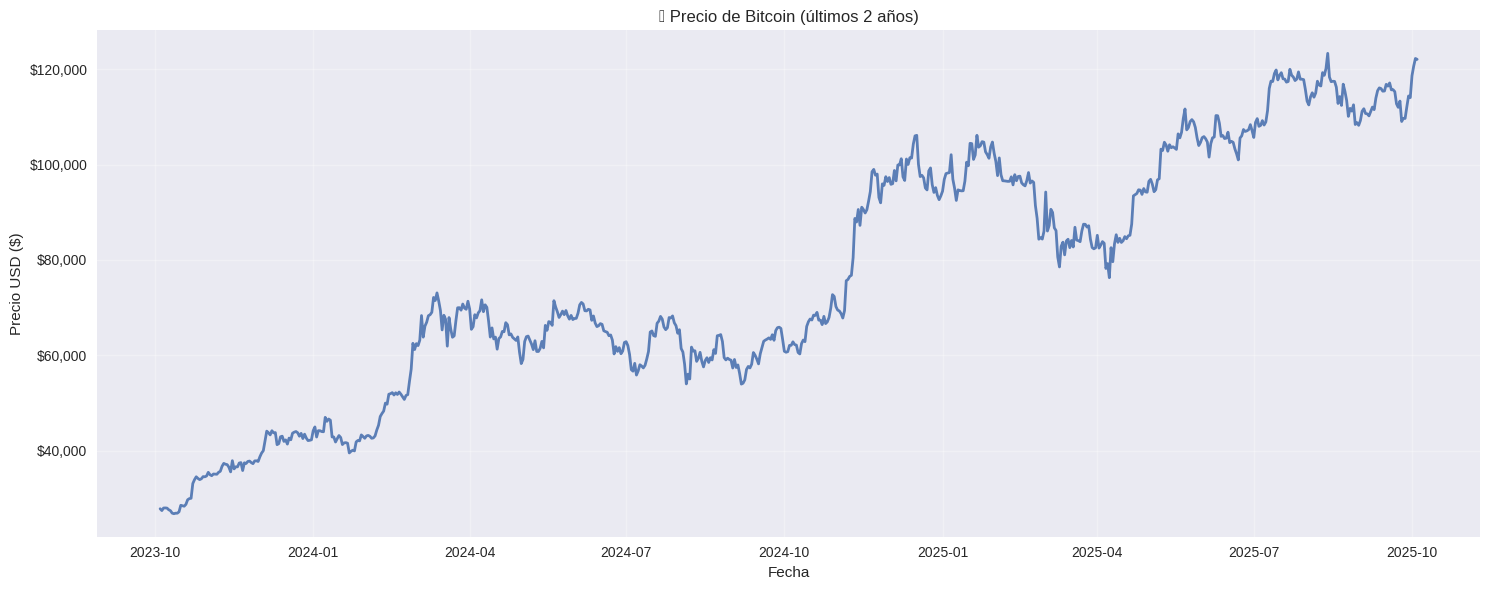

📊 Secuencias: train=560 | val=141 | ventana=30 | horizonte=7
📚 Entrenando 120 epochs (PyTorch)…
Epoch 001 | train 0.238304 | val 0.055968
⏹️ Early stopping en epoch 15


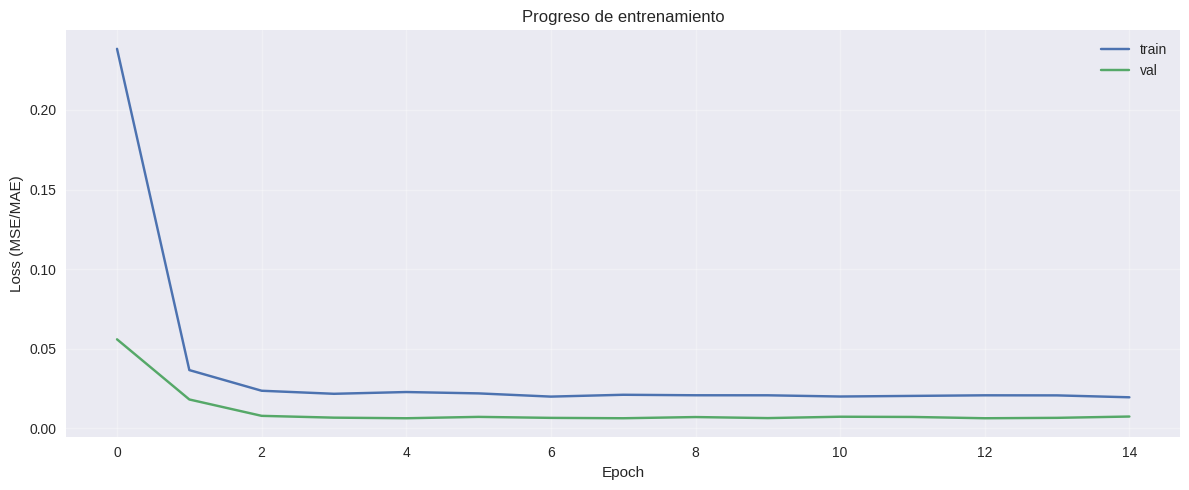

📏 MAE 1-paso (returns) | modelo: 0.012037 | persistencia: 0.012036

🔮 Predicción 7 días (precios):
   Día 1: $122,192.09
   Día 2: $122,299.55
   Día 3: $122,407.08
   Día 4: $122,515.20
   Día 5: $122,624.27
   Día 6: $122,734.48
   Día 7: $122,845.29

💰 Precio actual de Bitcoin: $122,082.37
📈 Precio promedio predicho: $122,516.85
📊 Cambio predicho (media 7d): +0.36%


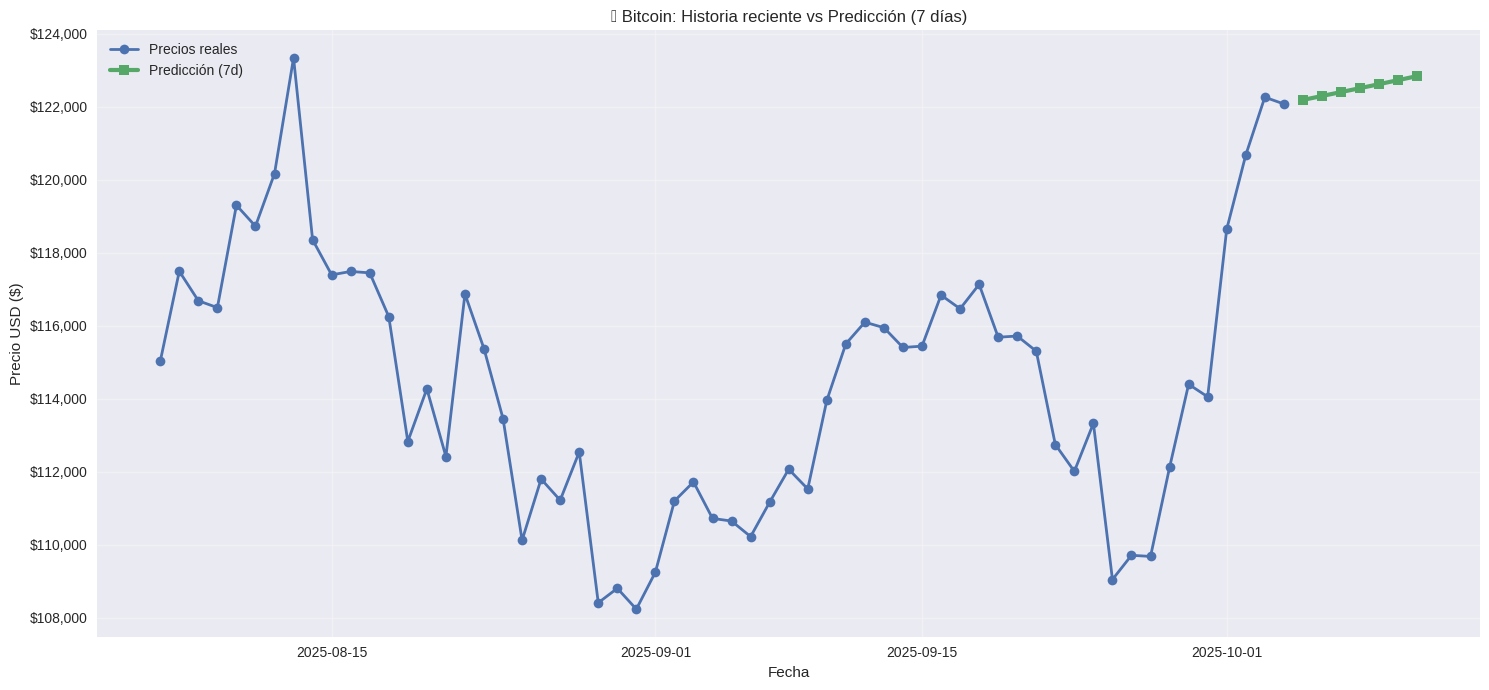

In [8]:
def ejecutar():
    print("\n🌟 PIPELINE COMPLETO")
    precios, fechas = descargar_datos_bitcoin()

    # Visualización de precios bruta (se omite si no hay matplotlib)
    visualizar_precios(precios, fechas)

    ventana = 30
    horizonte = 7

    # Secuencias sin escalar (para evitar leakage)
    X_raw, y_raw, r_stream = construir_secuencias_returns(precios, ventana=ventana)

    # Split por secuencias
    n = len(X_raw)
    if n < 50:
        raise RuntimeError(f"Muy pocos datos para entrenar (n={n}). Genera/descarga más historia.")
    n_train = int(n * 0.8)

    X_train_raw, y_train_raw = X_raw[:n_train], y_raw[:n_train]
    X_val_raw, y_val_raw = X_raw[n_train:], y_raw[n_train:]

    # Fit scaler SOLO con datos de train (valores que aparecen en las ventanas de train)
    # Aquí **aplanamos** para obtener una única columna de returns (no cambia el nº de features del modelo)
    train_stream = np.concatenate([X_train_raw.reshape(-1), y_train_raw.reshape(-1)])
    scaler = MinMaxScaler().fit(train_stream.reshape(-1, 1))

    # Transformar todo a normalizado, manteniendo la forma [n_seq, ventana]
    def transform_Xy(Xu, yu):
        Xt = scaler.transform(Xu.reshape(-1, 1)).reshape(Xu.shape)
        yt = scaler.transform(yu.reshape(-1, 1)).reshape(yu.shape)
        return Xt, yt

    X_train, y_train = transform_Xy(X_train_raw, y_train_raw)
    X_val, y_val = transform_Xy(X_val_raw, y_val_raw)

    print(f"📊 Secuencias: train={len(X_train)} | val={len(X_val)} | ventana={ventana} | horizonte={horizonte}")

    # Entrenamiento (según backend disponible)
    model, tr_losses, va_losses = entrenar_modelo(X_train, y_train, X_val, y_val, epochs=120)

    # Curva de pérdidas (si hay matplotlib y más de un punto)
    if PLOT and len(tr_losses) > 1:
        plt.figure(figsize=(12, 5))
        plt.plot(tr_losses, label='train')
        plt.plot(va_losses, label='val')
        plt.title('Progreso de entrenamiento')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE/MAE)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    elif len(tr_losses) > 0:
        print("🖼️ [Gráfico de pérdidas omitido] Últimos valores →",
              f"train: {tr_losses[-1]:.6f} | val: {va_losses[-1]:.6f}")

    # Baseline 1-paso en returns (persistencia = 0 retorno)
    y_val_pred_1 = []
    for i in range(len(X_val)):
        yb = _predict_one_norm(model, X_val[i])
        y_val_pred_1.append(yb)
    y_val_pred_1 = np.array(y_val_pred_1).reshape(-1, 1)
    y_val_pred_1_real = scaler.inverse_transform(y_val_pred_1).reshape(-1)
    y_val_real = scaler.inverse_transform(y_val).reshape(-1)

    mae_model_1 = mean_absolute_error(y_val_real, y_val_pred_1_real)
    mae_persist_1 = mean_absolute_error(y_val_real, np.zeros_like(y_val_real))
    print(f"📏 MAE 1-paso (returns) | modelo: {mae_model_1:.6f} | persistencia: {mae_persist_1:.6f}")

    # Predicción real a 7 días desde la última ventana disponible
    ultimos_returns_norm = scaler.transform(X_raw[-1].reshape(-1,1)).reshape(-1)
    pred_returns_7 = predecir_returns_autoregresivo(model, ultimos_returns_norm, scaler, dias=horizonte)
    pred_precios_7 = reconstruir_precios_desde_returns(pred_returns_7, last_price=precios[-1])

    # Reporte y visualización final
    print("\n🔮 Predicción 7 días (precios):")
    for i, p in enumerate(pred_precios_7, 1):
        print(f"   Día {i}: ${float(p):,.2f}")

    print(f"\n💰 Precio actual de Bitcoin: ${float(precios[-1]):,.2f}")
    print(f"📈 Precio promedio predicho: ${float(np.mean(pred_precios_7)):,.2f}")
    cambio_pred = ((np.mean(pred_precios_7) - precios[-1]) / precios[-1]) * 100
    print(f"📊 Cambio predicho (media 7d): {cambio_pred:+.2f}%")

    # Plot comparación últimos 60 días + 7 predichos (si hay matplotlib)
    if PLOT:
        ultimos_dias_hist = 60
        fechas_recientes = fechas[-ultimos_dias_hist:]
        precios_recientes = precios[-ultimos_dias_hist:]
        fechas_futuras = pd.date_range(start=fechas[-1] + pd.Timedelta(days=1), periods=horizonte, freq='D')

        plt.figure(figsize=(15, 7))
        plt.plot(fechas_recientes, precios_recientes, 'o-', label='Precios reales', linewidth=2)
        plt.plot(fechas_futuras, pred_precios_7, 's-', label='Predicción (7d)', linewidth=3, markersize=7)
        plt.title('🚀 Bitcoin: Historia reciente vs Predicción (7 días)')
        plt.xlabel('Fecha')
        plt.ylabel('Precio USD ($)')
        ax = plt.gca()
        if FuncFormatter is not None:
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("🖼️ [Gráfico final omitido] Últimos reales y predicciones:")
        print("   Últimos 3 reales:", [f"${float(x):,.2f}" for x in precios[-3:]])
        print("   Predicción 7d:", [f"${float(x):,.2f}" for x in pred_precios_7])

    return {
        'model': model,
        'scaler': scaler,
        'ventana': ventana,
        'horizonte': horizonte,
        'precios': precios,
        'fechas': fechas,
        'pred_precios_7': pred_precios_7,
        'pred_returns_7': pred_returns_7,
        'mae_1step_model': mae_model_1,
        'mae_1step_persist': mae_persist_1,
    }


if __name__ == "__main__":
    # Ejecuta primero los tests de humo. Si algo básico falla, aborta temprano con un assert legible.
    run_smoke_tests()
    # Ejecuta el pipeline completo
    ejecutar()


# Notas adicionales sobre el ejercicio


🤔 ¿QUÉ ACABAS DE VER?

1. DATOS REALES: Descargamos precios reales de Bitcoin (no inventados)

2. TRANSFORMER: Un modelo de IA que:
   - Mira los últimos 30 días de precios
   - Encuentra patrones complejos automáticamente
   - Predice los próximos 7 días

3. MECANISMO DE ATENCIÓN: El transformer "se fija" en los días más importantes
   del pasado para hacer su predicción

4. ENTRENAMIENTO: El modelo aprendió de ~600 días de datos históricos

🚨 IMPORTANTE:
- Esto es un EJEMPLO EDUCATIVO
- Predecir Bitcoin es extremadamente difícil (¡hasta para los expertos!)
- NUNCA tomes decisiones financieras basándote solo en un modelo
- Los mercados son impredecibles y pueden cambiar por noticias, regulaciones, etc.

🎯 LO QUE SÍ PUEDES HACER:
- Aplicar esta misma técnica a:
  * Ventas de tu empresa
  * Demanda de productos
  * Tráfico web
  * Consumo energético
  * ¡Cualquier cosa que cambie con el tiempo!

💡 PRÓXIMOS PASOS:
- Experimenta con diferentes parámetros
- Prueba con tus propios datos
- Añade más variables (volumen, noticias, etc.)
- Mejora la visualización